# Creating a Gravest Empirical Mode (GEM) field of the standing meander

In [1]:
%run ../../_setup.py

import numpy as np
from netCDF4 import Dataset
from scipy.interpolate import UnivariateSpline, LinearNDInterpolator
from shutil import copyfile

from OceanPy.netcdf import createNetCDF

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cmocean as cmo


In [2]:
savefig = False

Load ctd data and show variables stored in NetCDF file

In [3]:
# load ctd and gsw data
input_file = os.path.join(datadir, 'processed', 'ss9802', 'ctd', 'ss9802_ctd_gsw.nc')
ctd = Dataset(input_file, 'r')
ctd.variables.keys()

odict_keys(['station', 'time', 'lon', 'lat', 'bot_lon', 'bot_lat', 'depth', 'p', 't', 'SP', 'O2', 'ts_t', 'ts_SP', 'ts_O2', 'SA', 'CT', 'g', 'z', 'pt', 'sigma0', 'spiciness0', 'deltaD', 'lonv', 'latv', 'Vg', 'gamman'])

Create Dynamic Height contours with the reference level (1494 dbar) considered as the level of 'no-motion'

In [4]:
# find indices for pressure levels in CTD prodiles
pressure_levels = {}
for ip, p in enumerate(ctd['p'][:]):
    pressure_levels[p] = ip

# define reference and interest level 
# p_ref = 1494
p_int = 2

# get dynamic height contours
D = np.array([ctd['deltaD'][profile, pressure_levels[p_int]] / 
              ctd['g'][profile, pressure_levels[p_int]]
              for profile in range(len(ctd.dimensions['profile']))])


/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Warning: converting a masked element to nan.
  del sys.path[0]


Fit a spline function for the various variables at each depth level 

In [5]:
odds = [1, 2, 9, 10, 11, 12, 27, 45, 46, 47, 75, 76, 77, 78, 101]
iodds = [istat for istat, station in enumerate(ctd['station']) if station in odds]

# variables = ['CT', 'SA', 'z']#['t', 'SP', 'CT', 'pt', 'SA', 'sigma0']
# splines = {}

# xinterp = np.linspace(np.nanmin(D[2:]), np.nanmax(D[2:]), 100)
# for p in ctd['p'][:]:
#     splines[p] = {}
#     for var in variables:
#         mask = np.ma.masked_where((np.isnan(D)) | (np.ma.masked_invalid(ctd[var][:, pressure_levels[p]]).mask) | 
#                                   ([station in odds for station in ctd['station']]), D).mask
#         try:
#             x, y = zip(*sorted(zip(D[~mask][2:], ctd[var][:, pressure_levels[p]][~mask][2:])))
#             splines[p][var] = UnivariateSpline(x, y)
#         except:
#             splines[p][var] = []


Plot the spline functions and indicate the outliers in yellow, the outliers are excluded from the interpolation.

In [6]:
# def label_point(x, y, val, ax):
#     for ix, iy, ival in zip(x, y, val):
#         if not any(np.isnan([ix, iy, ival])):
#             ax.text(ix+0.01, iy, str(ival), color='m')

# plvls = np.linspace(100, 1500, 15)
# for p in plvls:
#     fig, ax = plt.subplots(1, 3, figsize=(16,6))
#     for axis, var in enumerate(variables):
#         ax[axis].scatter(D[2:], ctd[var][2:, pressure_levels[p]], s=40, facecolors='gray')
#         ax[axis].scatter(D[iodds], ctd[var][iodds, pressure_levels[p]], s=40, facecolors='yellow')
#         ax[axis].plot(xinterp, splines[p][var](xinterp))
#         label_point(D[2:], ctd[var][2:, pressure_levels[p]], ctd['station'][2:], ax=ax[axis])
#         ax[axis].set_title(var)

#     fig.suptitle('Depth level: %s dbar' % p)


Create GEM

In [7]:
# GEM = {}
# for var in variables:
#     GEM[var] = np.ma.masked_all((ctd.dimensions['profile'].size, ctd.dimensions['plevel'].size))
#     for ip, p in enumerate(ctd['p'][:]):
#         try:
#             for id, d in enumerate(D):
#                 GEM[var][id, ip] = float(splines[p][var](d))
#         except TypeError:
#             pass

Open GEM

In [8]:
# load gem
input_file_gem = os.path.join(datadir, 'processed', 'ss9802', 'ctd', 'ss9802_ctd_gem.nc')
gem = Dataset(input_file_gem, 'r')
gem.variables.keys()

odict_keys(['t', 'SP', 'CT', 'pt', 'SA', 'sigma0', 'gamman'])

Plot the outliers on a map and compare to interpolated dynamic height contours.

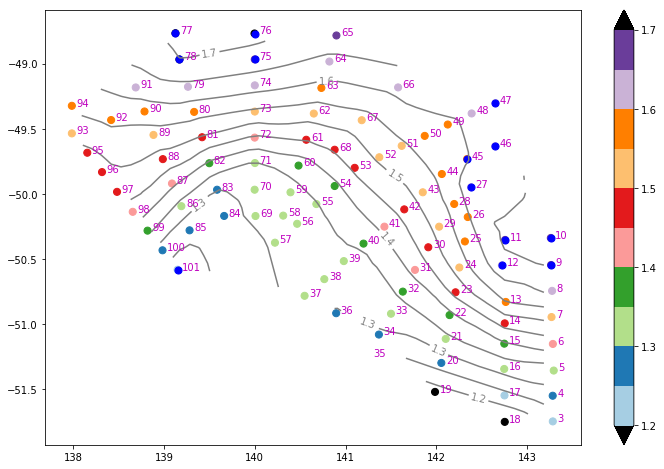

In [10]:
points = list(zip(ctd['lon'][2:, 0], ctd['lat'][2:, 0]))
lni = np.linspace(min(ctd['lon'][2:, 0]), max(ctd['lon'][2:, 0]))
lti = np.linspace(min(ctd['lat'][2:, 0]), max(ctd['lat'][2:, 0]))
lnln, ltlt = np.meshgrid(lni, lti)

interp = LinearNDInterpolator(points, D[2:])
DD = interp(lnln, ltlt)

fig, ax = plt.subplots(figsize=(12,8))

Dcontours = np.linspace(1.2, 1.7, 11)
cont = ax.contour(lnln, ltlt, DD, Dcontours, colors='gray')
ax.clabel(cont, Dcontours[::2], inline=1, fmt='%.1f')

ncolors = 10
colors = plt.cm.Paired(np.linspace(0, 1, ncolors+2))
cmap = mcolors.ListedColormap(colors[:-2], "")
cmap.set_under('k')
cmap.set_over('k')

bounds = np.linspace(1.2, 1.7, ncolors+1)
norm = mcolors.BoundaryNorm(bounds, ncolors=ncolors)

scat = ax.scatter(ctd['lon'][2:, 0], ctd['lat'][2:, 0], s=50, c=D[2:], cmap=cmap, norm=norm)
ax.scatter(ctd['lon'][iodds[2:], 0], ctd['lat'][iodds[2:], 0], s=50, c='b')

for ix, iy, ival in zip(ctd['lon'][2:, 0], ctd['lat'][2:, 0], ctd['station'][2:]):
    if not any(np.isnan([ix, iy, ival])):
        ax.text(ix+0.05, iy, str(ival), color='m')

fig.colorbar(scat, extend='both')

Plot measurements and GEM for several depth levels.

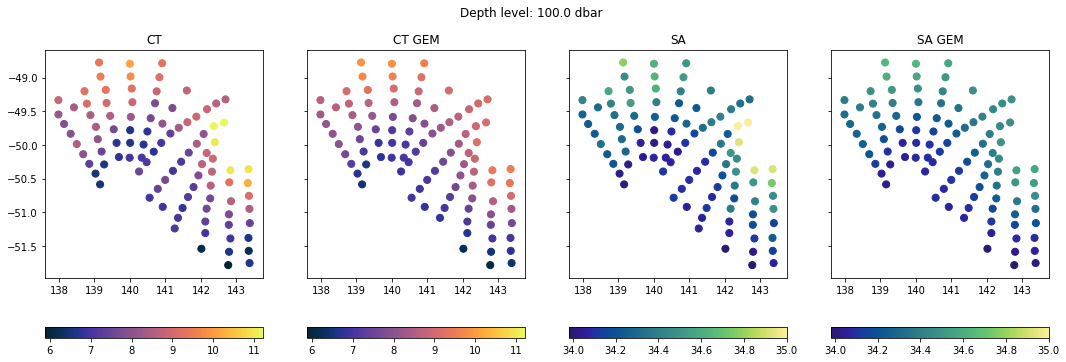

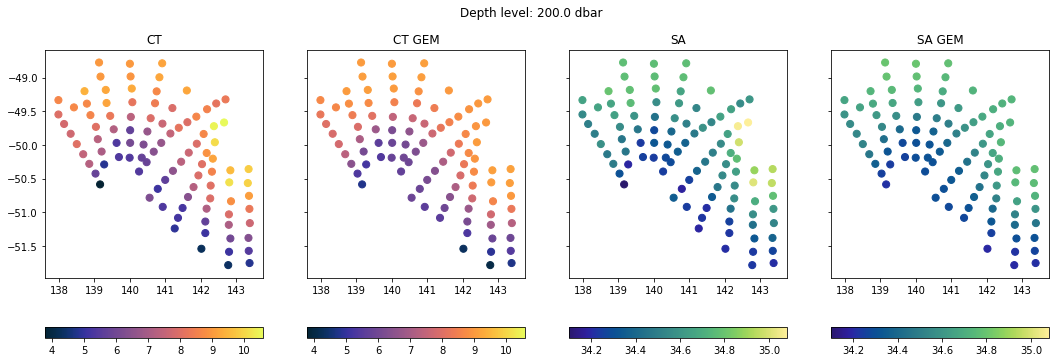

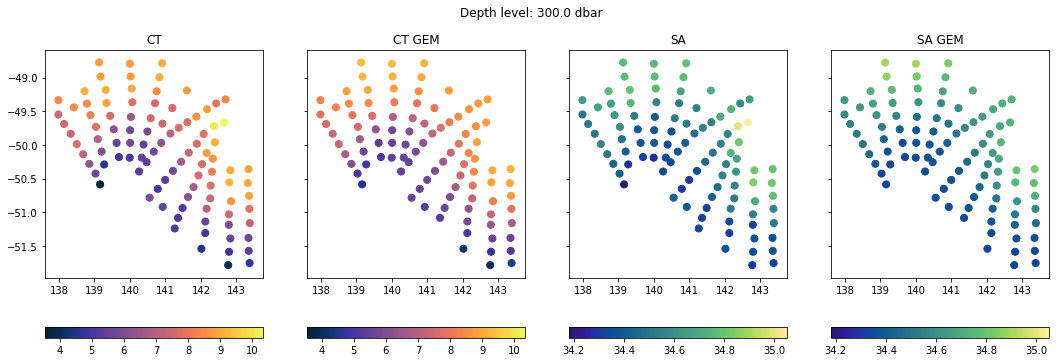

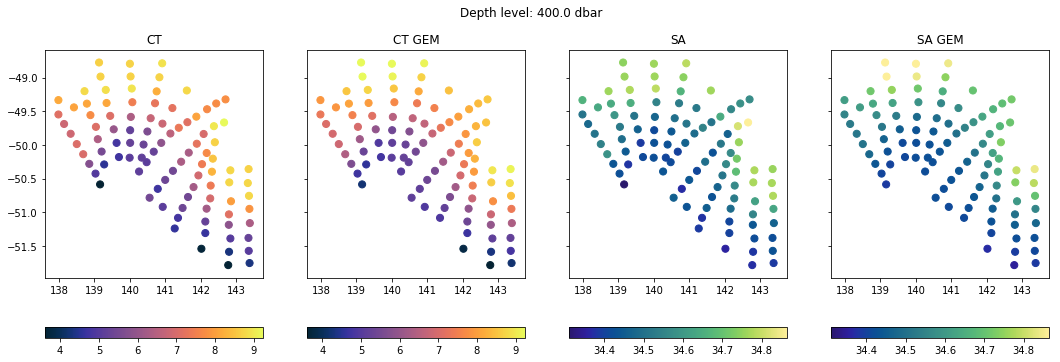

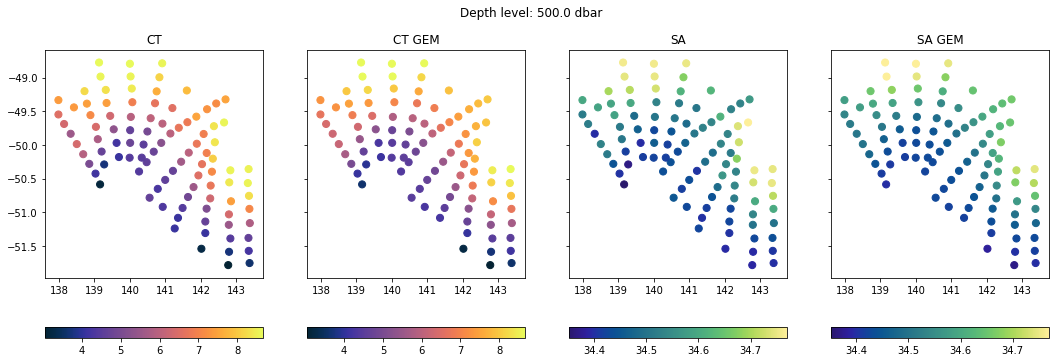

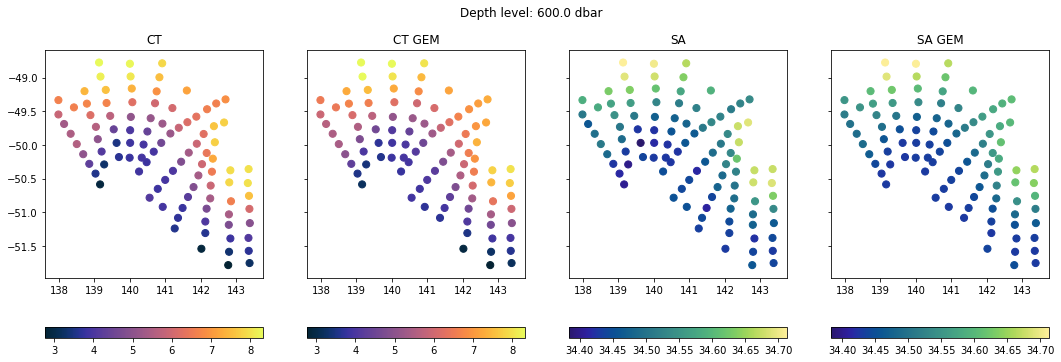

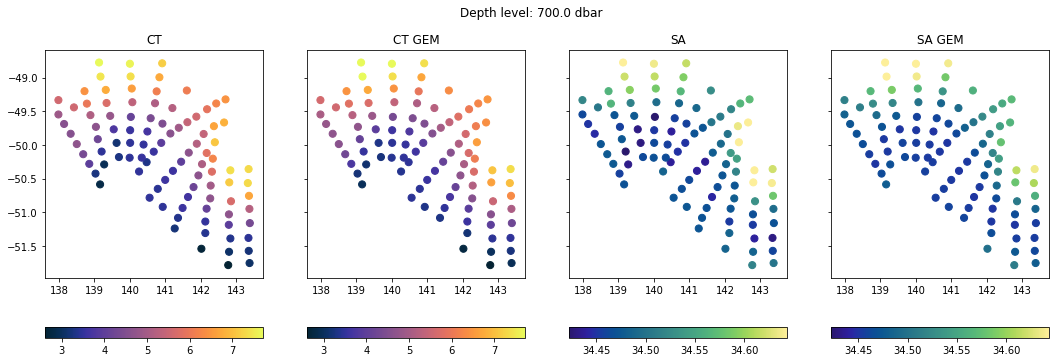

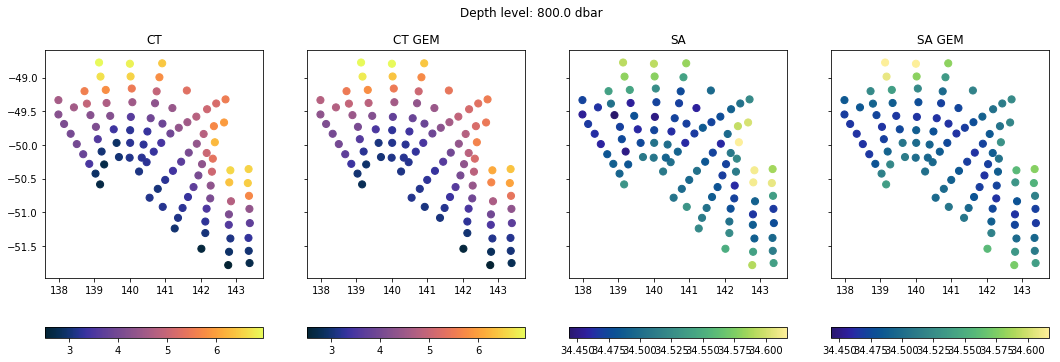

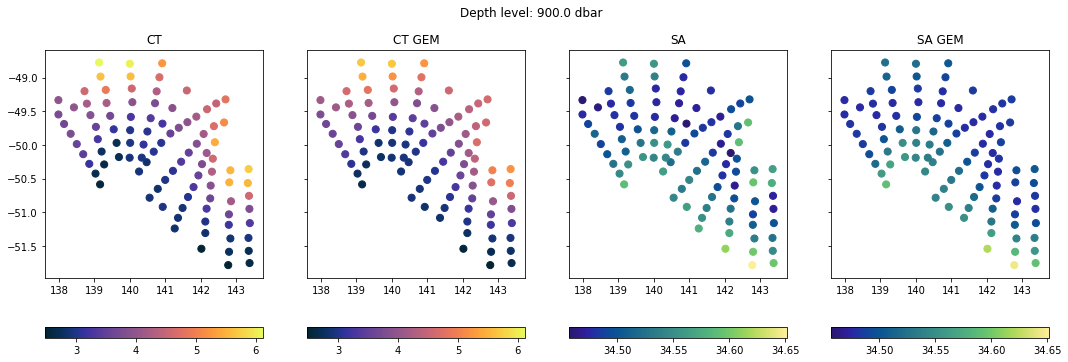

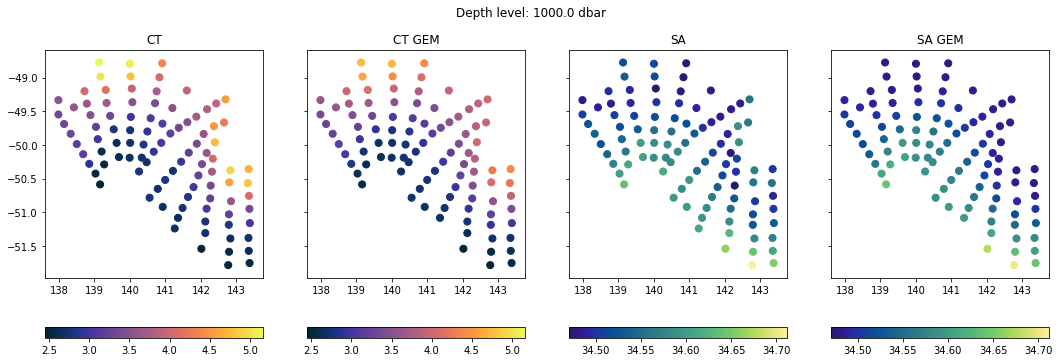

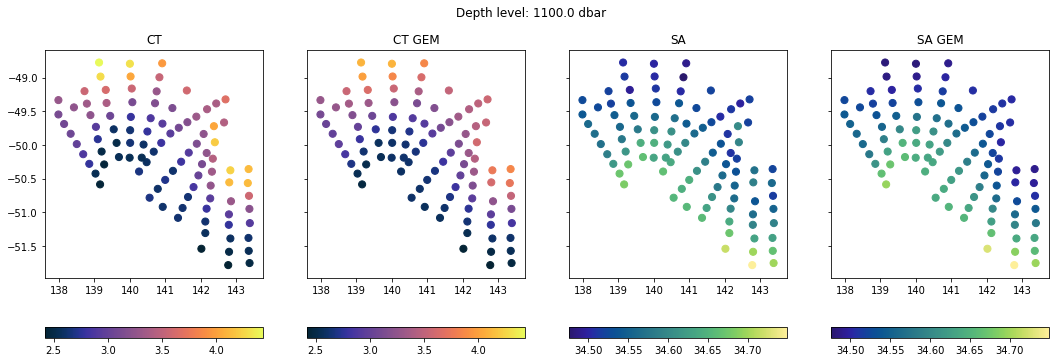

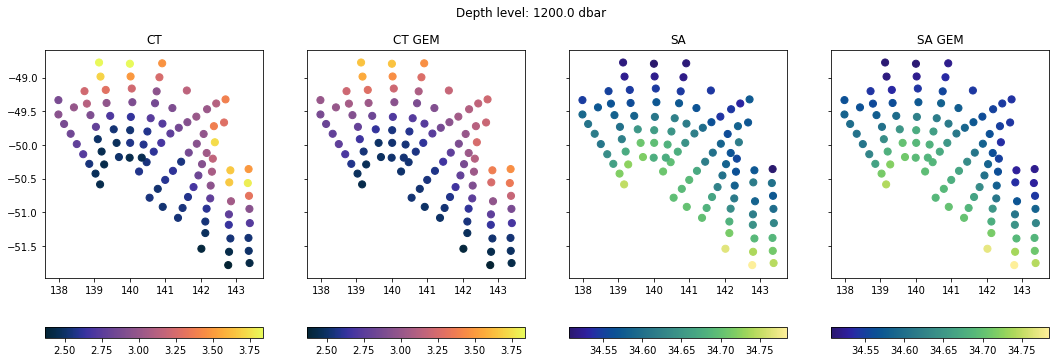

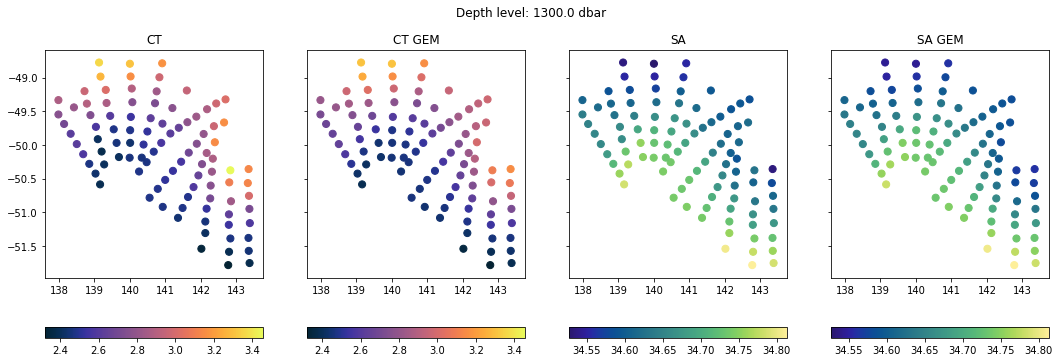

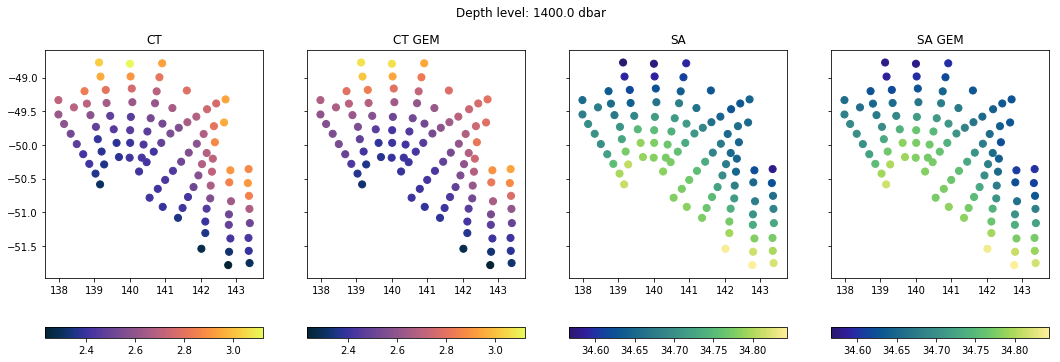

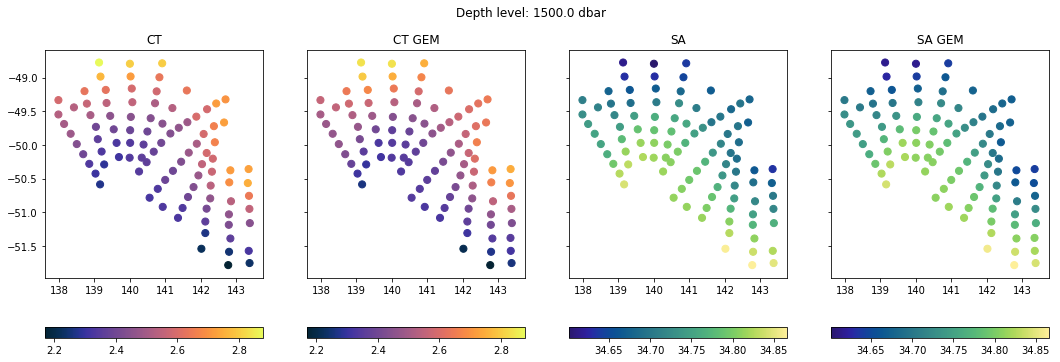

In [10]:
plvls = np.linspace(100, 1500, 15)
cmaps = {'CT': cmo.cm.thermal, 'SA': cmo.cm.haline, 'sigma0': cmo.cm.dense}
for p in plvls:
    fig, ax = plt.subplots(1, 4, figsize=(18,6), sharex=True, sharey=True)
    for axis, var in zip(range(0, 3, 2), sorted(cmaps.keys())):
#         print(axis, var)
        scat = ax[axis].scatter(ctd['lon'][2:, 1], ctd['lat'][2:, 1], c=ctd[var][2:, pressure_levels[p]], cmap=cmaps[var], s=50)
        plt.colorbar(scat, ax=ax[axis], orientation='horizontal')
        ax[axis].set_title(var)

        vmin, vmax = scat.get_clim()
        scat = ax[axis+1].scatter(ctd['lon'][2:, 1], ctd['lat'][2:, 1], c=gem[var][2:, pressure_levels[p]], cmap=cmaps[var], vmin=vmin, vmax=vmax, s=50)
        plt.colorbar(scat, ax=ax[axis+1], orientation='horizontal')
        ax[axis+1].set_title(var + ' GEM')
    fig.suptitle('Depth level: %s dbar' % p)

### N-S transect (3?) of potential density/ neutral density with indication of water masses

### GEM reference fields of temperature and salinity / T-S diagram against dynamic height


In [11]:
from scipy.interpolate import griddata

dD = 0.01
Di = np.linspace(np.nanmin(D), np.nanmax(D)) # , int((np.nanmax(D) - np.nanmin(D)) / dD + 1)

trues = np.isfinite(D)
trues[0], trues[1] = False, False
pp, DD = np.meshgrid(ctd['p'], D[trues])
Dgrd, pgrd = np.meshgrid(Di, ctd['p'][:])


variables = {'CT': cmo.cm.thermal, 'SA': cmo.cm.haline, 'gamman': cmo.cm.dense}
gem_ref = {}
for var in variables.keys():
    mask = gem[var][trues].mask
    points = list(zip(DD[~mask].flatten(), pp[~mask].flatten()))
    values = gem[var][trues][~mask].flatten()
    gem_ref[var] = griddata(points, values, (Dgrd, pgrd), method='linear')

In [12]:
CTi = np.linspace(np.nanmin(ctd['CT']), np.nanmax(ctd['CT']))
SAi = np.linspace(np.nanmin(ctd['SA']), np.nanmax(ctd['SA']))
SAgrd, ptgrd = np.meshgrid(SAi, CTi)
mask = gem['gamman'][trues].mask

points = list(zip(gem['SA'][trues][~mask], gem['CT'][trues][~mask]))
values = gem['gamman'][trues][~mask]
gammangrd = griddata(points, values, (SAgrd, ptgrd), method='linear')


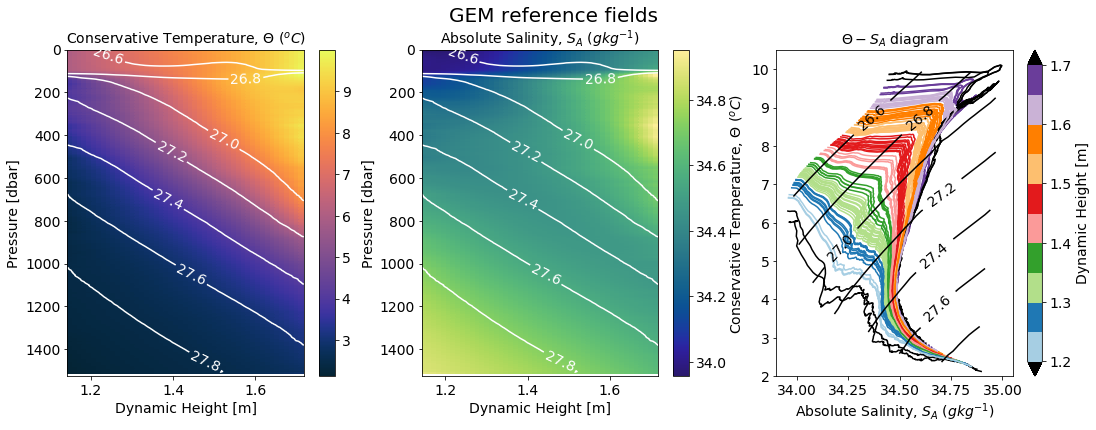

In [13]:
import cmocean as cmo

fs_small=14
fs_large=20

plt.rc('xtick',labelsize=fs_small)
plt.rc('ytick',labelsize=fs_small)

titles = {'CT': r'Conservative Temperature, $\Theta$ ($^o C$)', r'SA': 'Absolute Salinity, $S_A$ ($gkg^{-1}$)'}

ncolors = 10
bounds = np.linspace(1.2, 1.7, ncolors+1)

colors = plt.cm.Paired(np.linspace(0, 1, 12))
# colors = np.append(colors[:4], colors[6:], axis=0)
cmap = mcolors.ListedColormap(colors[:-2], "")
cmap.set_under('k')
cmap.set_over('k')

# cmap = plt.cm.Paired
# cmap.set_under('k')
# cmap.set_over("yellow")
norm = mcolors.BoundaryNorm(bounds, ncolors=ncolors)
# cmap = plt.cm.nipy_spectral
# norm = mcolors.BoundaryNorm(Dlin, ncolors=cmap.N)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
for axis, var in enumerate(variables.keys()):
    if axis == 2:
        for ist in range(len(ctd['station'])):
            if trues[ist]:
                ax[axis].plot(gem['SA'][ist], gem['CT'][ist], color=cmap(norm(D[ist])))
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array(bounds)
        cbar = plt.colorbar(sm, ax=ax[axis], orientation='vertical',extend='both')
        cbar.set_label('Dynamic Height [m]', fontsize=fs_small)
        
        cont = ax[axis].contour(SAi, CTi, gammangrd, colors='k', zorder=1000)
        ax[axis].clabel(cont, inline=1, fontsize=fs_small, fmt='%.1f')
        
        ax[axis].set_ylim([2, 10.5])
        ax[axis].set_xlim([33.9, 35.05])
        ax[axis].set_ylabel(titles['CT'], fontsize=fs_small)
        ax[axis].set_xlabel(titles['SA'], fontsize=fs_small)
        ax[axis].set_title(r'$\Theta-S_A$ diagram', fontsize=fs_small)

    else:
        pcol = ax[axis].pcolormesh(Dgrd, pgrd, gem_ref[var], cmap=variables[var])
        cont = ax[axis].contour(Dgrd, pgrd, gem_ref['gamman'], colors='w')
        ax[axis].invert_yaxis()
        ax[axis].clabel(cont, inline=1, fontsize=fs_small, fmt='%.1f')
        
        ax[axis].set_ylabel('Pressure [dbar]', fontsize=fs_small)
        ax[axis].set_xlabel('Dynamic Height [m]', fontsize=fs_small)
        ax[axis].set_title(titles[var], fontsize=fs_small)

        cbar = plt.colorbar(pcol, ax=ax[axis], orientation='vertical')

    plt.suptitle('GEM reference fields', fontsize=fs_large)


In [14]:
if savefig:
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', '03_reference-field' + extension))